In [10]:
import pandas as pd
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt  
import seaborn as sns

In [11]:
# Import the data data
subscriptions = pd.read_csv('subscriptionsdataFINAL.csv') 
visitation_part1 = pd.read_csv('visitationdataPART1.csv') 
visitation_part2 = pd.read_csv('visitationdataPART2.csv')  

In [12]:
# Chane the timestamp
subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions['Join_year'] = pd.DatetimeIndex(subscriptions['Join Date']).year
subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions.dropna()
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015


In [13]:
## Add the duration data to the subscriptions data
date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
dates = pd.date_range(date_min, date_max, freq = 'MS')
customers_total = pd.DataFrame({'Date':dates})
customers_total.head(), customers_total.shape
subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                     (date_max - subscriptions['Join Date']), 
                                     (subscriptions['End Date'] - subscriptions['Join Date']) )
subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                     (date_max - subscriptions['Join Date']), 
                                     (subscriptions['End Date'] - subscriptions['Join Date']) )
##convert the difference in months
subscriptions['Duration'] = (subscriptions['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
subscriptions

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Duration
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,0
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018,6
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,7
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,2
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,7
...,...,...,...,...,...,...,...,...,...,...
850028,Lewisham,2018-12-01,A,Male,Standard,NaT,850029,1995,2018,0
850029,Tower Hamlets,2013-10-01,B,Male,Standard,2014-02-01,850030,1987,2013,4
850030,Redbridge,2018-05-01,C1,Female,Standard,2018-09-01,850031,1985,2018,4
850031,Camden,2017-07-01,B,Female,Standard,2017-09-01,850032,1978,2017,2


In [16]:
# Monthly
# Calculate the number of member joined, the number of member left, net member, cumulative member
member_joined_data = subscriptions.groupby(['Join Date','Affluence']).size().reset_index(name='Number_of_Member_Joined')
member_joined_data = member_joined_data.rename(columns={'Join Date': "Date"})
member_left_data = subscriptions.groupby(['End Date','Affluence']).size().reset_index(name='Number_of_Member_Left')
member_left_data=member_left_data.rename(columns={'End Date': "Date"})
member_left_data['Date']=member_left_data['Date'] + pd.DateOffset(months=1)
member_data = pd.merge(member_joined_data,member_left_data,on = ['Affluence','Date'],how='outer').sort_index().replace({np.nan:0})
member_data['Net_Member'] = member_data['Number_of_Member_Joined'] - member_data['Number_of_Member_Left'] 
member_data = pd.DataFrame(member_data.groupby(['Date','Affluence']).sum())
member_data['Cumulative_Member'] = member_data.groupby(level=-1)['Net_Member'].cumsum()
member_data_breakdown_by_club = member_data.copy()
member_data

Number_of_Member_Joined  Number_of_Member_Left  \
Date       Affluence                                                   
2009-05-01 A                            141.0                    0.0   
           B                            253.0                    0.0   
           C1                           212.0                    0.0   
           C2                            89.0                    0.0   
           DE                             4.0                    0.0   
...                                       ...                    ...   
2019-01-01 A                              0.0                 2126.0   
           B                              0.0                 5425.0   
           C1                             0.0                 3386.0   
           C2                             0.0                 1392.0   
           DE                             0.0                  195.0   

                      Net_Member  Cumulative_Member  
Date       Affluence                                 
2009-05-01 A               141.0              141.0  
           B               253.0              253.0  
           C1              212.0              212.0  
           C2               89.0               89.0  
           DE                4.0                4.0  
...                          ...                ...  
2019-01-01 A             -2126.0             9475.0  
           B             -5425.0            22119.0  
           C1            -3386.0            14473.0  
           C2            -1392.0             5704.0  
           DE             -195.0              606.0  

[585 rows x 4 columns]

In [17]:
# Monthly
# Calculate the revenue
date_while_price_changed = pd.Timestamp('2016-01-01') 
date_min = pd.Timestamp('2009-05-01') 
date_max = pd.Timestamp('2019-01-01') 
dates_before_price_change = pd.date_range(date_min, date_while_price_changed, freq = 'MS')
dates_after_price_change = pd.date_range(date_while_price_changed, date_max, freq = 'MS')
A_data = pd.DataFrame(member_data.xs('A', level=1, drop_level=False))
B_data = pd.DataFrame(member_data.xs('B', level=1, drop_level=False))
C1_data = pd.DataFrame(member_data.xs('C1', level=1, drop_level=False))
C2_data = pd.DataFrame(member_data.xs('C2', level=1, drop_level=False))
DE_data = pd.DataFrame(member_data.xs('DE', level=1, drop_level=False))

A_data.loc[dates_before_price_change,'Membership_Revenue'] = A_data.loc[dates_before_price_change,'Cumulative_Member'] * 25.99
A_data.loc[dates_after_price_change,'Membership_Revenue'] = A_data.loc[dates_after_price_change,'Cumulative_Member'] * 30.99
B_data.loc[dates_before_price_change,'Membership_Revenue'] = B_data.loc[dates_before_price_change,'Cumulative_Member'] * 20.99
B_data.loc[dates_after_price_change,'Membership_Revenue'] = B_data.loc[dates_after_price_change,'Cumulative_Member'] * 26.99
C1_data.loc[dates_before_price_change,'Membership_Revenue'] = C1_data.loc[dates_before_price_change,'Cumulative_Member'] * 25.99
C1_data.loc[dates_after_price_change,'Membership_Revenue'] = C1_data.loc[dates_after_price_change,'Cumulative_Member'] * 30.99
C2_data.loc[dates_before_price_change,'Membership_Revenue'] = C2_data.loc[dates_before_price_change,'Cumulative_Member'] * 20.99
C2_data.loc[dates_after_price_change,'Membership_Revenue'] = C2_data.loc[dates_after_price_change,'Cumulative_Member'] * 26.99
DE_data.loc[dates_before_price_change,'Membership_Revenue'] = DE_data.loc[dates_before_price_change,'Cumulative_Member'] * 25.99
DE_data.loc[dates_after_price_change,'Membership_Revenue'] = DE_data.loc[dates_after_price_change,'Cumulative_Member'] * 30.99


A_data = A_data['Membership_Revenue']
B_data = B_data['Membership_Revenue']
C1_data = C1_data['Membership_Revenue']
C2_data = C2_data['Membership_Revenue']
DE_data = DE_data['Membership_Revenue']


Revenue_data = pd.DataFrame(pd.concat([A_data, B_data,C1_data,C2_data,DE_data]))

member_data = pd.merge(member_data,Revenue_data,on = ['Date','Affluence'],how='left')
member_data['Join_Revenue'] = member_data['Number_of_Member_Joined'] * 5
member_data['Total_Revenue'] = member_data['Membership_Revenue'] +  member_data['Join_Revenue']
member_data

Number_of_Member_Joined  Number_of_Member_Left  \
Date       Affluence                                                   
2009-05-01 A                            141.0                    0.0   
           B                            253.0                    0.0   
           C1                           212.0                    0.0   
           C2                            89.0                    0.0   
           DE                             4.0                    0.0   
...                                       ...                    ...   
2019-01-01 A                              0.0                 2126.0   
           B                              0.0                 5425.0   
           C1                             0.0                 3386.0   
           C2                             0.0                 1392.0   
           DE                             0.0                  195.0   

                      Net_Member  Cumulative_Member  Membership_Revenue  \
Date       Affluence                                                      
2009-05-01 A               141.0              141.0             3664.59   
           B               253.0              253.0             5310.47   
           C1              212.0              212.0             5509.88   
           C2               89.0               89.0             1868.11   
           DE                4.0                4.0              103.96   
...                          ...                ...                 ...   
2019-01-01 A             -2126.0             9475.0           293630.25   
           B             -5425.0            22119.0           596991.81   
           C1            -3386.0            14473.0           448518.27   
           C2            -1392.0             5704.0           153950.96   
           DE             -195.0              606.0            18779.94   

                      Join_Revenue  Total_Revenue  
Date       Affluence                               
2009-05-01 A                 705.0        4369.59  
           B                1265.0        6575.47  
           C1               1060.0        6569.88  
           C2                445.0        2313.11  
           DE                 20.0         123.96  
...                            ...            ...  
2019-01-01 A                   0.0      293630.25  
           B                   0.0      596991.81  
           C1                  0.0      448518.27  
           C2                  0.0      153950.96  
           DE                  0.0       18779.94  

[585 rows x 7 columns]

In [18]:
# Yearly
# The number of members and the total revenue
member_data_yearly=member_data.reset_index()
member_data_yearly['Year'] = member_data_yearly.apply(lambda row: row['Date'].year,axis=1)
member_data_yearly=member_data_yearly.groupby(['Year','Affluence']).sum()
member_data_yearly.head()

Number_of_Member_Joined  Number_of_Member_Left  Net_Member  \
Year Affluence                                                               
2009 A                           1615.0                  504.0      1111.0   
     B                           3714.0                 1203.0      2511.0   
     C1                          2539.0                  852.0      1687.0   
     C2                          1066.0                  366.0       700.0   
     DE                           105.0                   31.0        74.0   

                Cumulative_Member  Membership_Revenue  Join_Revenue  \
Year Affluence                                                        
2009 A                     5058.0           131457.42        8075.0   
     B                    10891.0           228602.09       18570.0   
     C1                    7680.0           199603.20       12695.0   
     C2                    3234.0            67881.66        5330.0   
     DE                     290.0             7537.10         525.0   

                Total_Revenue  
Year Affluence                 
2009 A              139532.42  
     B              247172.09  
     C1             212298.20  
     C2              73211.66  
     DE               8062.10

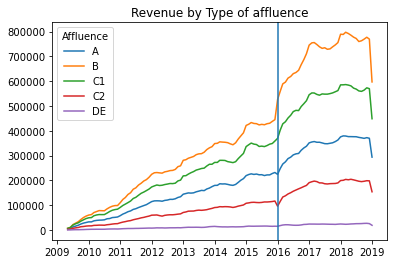

In [19]:
#Plot the chart of monthly revenue
date_min = pd.Timestamp('2009-05-01') 
date_max = pd.Timestamp('2019-01-01') 
Date = pd.date_range(date_min, date_max, freq = 'MS')
A_data = pd.DataFrame(member_data.xs('A', level=1, drop_level=False))
B_data = pd.DataFrame(member_data.xs('B', level=1, drop_level=False))
C1_data = pd.DataFrame(member_data.xs('C1', level=1, drop_level=False))
C2_data = pd.DataFrame(member_data.xs('C2', level=1, drop_level=False))
DE_data = pd.DataFrame(member_data.xs('DE', level=1, drop_level=False))

A = A_data['Total_Revenue']
B = B_data['Total_Revenue']
C1 = C1_data['Total_Revenue']
C2 = C2_data['Total_Revenue']
DE = DE_data['Total_Revenue']

plt.plot(Date,A,label='A')
plt.plot(Date,B,label='B')
plt.plot(Date,C1,label='C1')
plt.plot(Date,C2,label='C2')
plt.plot(Date,DE,label='DE')

plt.legend(title='Affluence')
plt.title('Revenue by Type of Affluence')
plt.axvline(x='2016-01-01')

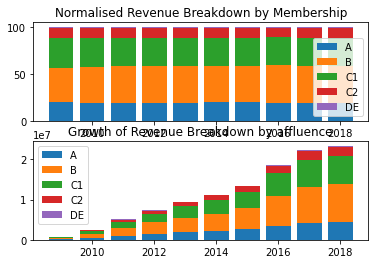

In [20]:
# Plot the Percent stacked barplot and barplot of yearly revenue,seperating the Affluence
r =  np.arange(2009,2019)

A_data = pd.DataFrame(member_data_yearly.xs('A', level=1, drop_level=False)).drop([2019])
B_data = pd.DataFrame(member_data_yearly.xs('B', level=1, drop_level=False)).drop([2019])
C1_data = pd.DataFrame(member_data_yearly.xs('C1', level=1, drop_level=False)).drop([2019])
C2_data = pd.DataFrame(member_data_yearly.xs('C2', level=1, drop_level=False)).drop([2019])
DE_data = pd.DataFrame(member_data_yearly.xs('DE', level=1, drop_level=False)).drop([2019])

A_Revenue = A_data['Total_Revenue']
B_Revenue = B_data['Total_Revenue']
C1_Revenue = C1_data['Total_Revenue']
C2_Revenue = C2_data['Total_Revenue']
DE_Revenue = DE_data['Total_Revenue']

totals = [i+j+a+b+c for i,j,a,b,c in zip(A_Revenue, B_Revenue,C1_Revenue, C2_Revenue,DE_Revenue)]

A_revenue_stacked = [i / j * 100 for i,j in zip(A_Revenue, totals)]
B_revenue_stacked = [i / j * 100 for i,j in zip(B_Revenue, totals)] 
C1_revenue_stacked = [i / j * 100 for i,j in zip(C1_Revenue, totals)]
C2_revenue_stacked = [i / j * 100 for i,j in zip(C2_Revenue, totals)] 
DE_revenue_stacked = [i / j * 100 for i,j in zip(DE_Revenue, totals)]

plt.subplot(2, 1, 1)
plt.bar(r,A_revenue_stacked,label='A')
plt.bar(r,B_revenue_stacked, bottom=A_revenue_stacked,label='B')
plt.bar(r,C1_revenue_stacked, bottom=[i+j for i,j in zip(A_revenue_stacked, B_revenue_stacked)],label='C1')
plt.bar(r,C2_revenue_stacked, bottom=[i+j+a for i,j,a in zip(A_revenue_stacked, B_revenue_stacked,C1_revenue_stacked)],label='C2')
plt.bar(r,DE_revenue_stacked, bottom=[i+j+a+b for i,j,a,b in zip(A_revenue_stacked, B_revenue_stacked,C1_revenue_stacked,C2_revenue_stacked)],label='DE')
plt.title('Normalised Revenue Breakdown by Affluence')
plt.legend()
plt.subplot(2, 1, 2)

plt.bar(r,A_Revenue,label='A')
plt.bar(r,B_Revenue, bottom=A_Revenue,label='B')
plt.bar(r,C1_Revenue, bottom=[i+j for i,j in zip(A_Revenue, B_Revenue)],label='C1')
plt.bar(r,C2_Revenue, bottom=[i+j+a for i,j,a in zip(A_Revenue, B_Revenue,C1_Revenue)],label='C2')
plt.bar(r,DE_Revenue, bottom=[i+j+a+b for i,j,a,b in zip(A_Revenue, B_Revenue,C1_Revenue,C2_Revenue)],label='DE')
plt.title('Growth of Revenue Breakdown by Affluence')
plt.legend()
plt.show()

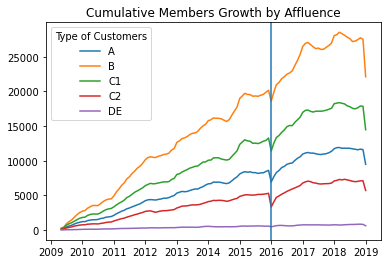

In [24]:
# Plot the cumulative members monthly
Dates = pd.date_range(min(Date), max(Date), freq = 'MS')
A = member_data.xs('A', level=1, drop_level=False)['Cumulative_Member']
B = member_data.xs('B', level=1, drop_level=False)['Cumulative_Member']
C1 = member_data.xs('C1', level=1, drop_level=False)['Cumulative_Member']
C2 = member_data.xs('C2', level=1, drop_level=False)['Cumulative_Member']
DE = member_data.xs('DE', level=1, drop_level=False)['Cumulative_Member']

plt.plot(Dates,A,label='A')
plt.plot(Dates,B,label='B')
plt.plot(Dates,C1,label='C1')
plt.plot(Dates,C2,label='C2')
plt.plot(Dates,DE,label='DE')
plt.title('Cumulative Members by Affluence')
plt.legend(title='Type of Customers')
plt.axvline(x='2016-01-01')

In [22]:
# Breakdown by club and Affluence
number_of_member_breakdown_by_club = subscriptions.groupby(['Club','Affluence','Join_year']).size().reset_index(name='Number_of_Member')
number_of_member_breakdown_by_club.head(10)

,Club,Affluence,Join_year,Number_of_Member
0,Barking,A,2016,883
1,Barking,A,2017,1009
2,Barking,A,2018,907
3,Barking,B,2016,2272
4,Barking,B,2017,2549
5,Barking,B,2018,2464
6,Barking,C1,2016,1377
7,Barking,C1,2017,1593
8,Barking,C1,2018,1530
9,Barking,C2,2016,549


In [23]:
# Calculate the number of member breakdown by club in a specific year
def calculate_number_of_member_breakdown_by_club(year,affluence,number):
    number_of_member_breakdown_by_club_year=number_of_member_breakdown_by_club.loc[number_of_member_breakdown_by_club['Join_year'] == 2016]
    sum_number_of_member_breakdown_by_club_year = number_of_member_breakdown_by_club_year.groupby(['Club']).sum(['Number_of_Member']).drop(columns=['Join_year'])
    number_of_member_breakdown_by_club_year=number_of_member_breakdown_by_club_year.merge(sum_number_of_member_breakdown_by_club_year, how='left', on='Club')
    number_of_member_breakdown_by_club_year['Affluence_percentage'] = number_of_member_breakdown_by_club_year['Number_of_Member_x'] / number_of_member_breakdown_by_club_year['Number_of_Member_y']
    number_of_member_breakdown_by_club_year=number_of_member_breakdown_by_club_year.drop(columns=['Number_of_Member_x','Number_of_Member_y','Join_year'])
    return number_of_member_breakdown_by_club_year.loc[number_of_member_breakdown_by_club_year['Affluence'] == affluence].nlargest(number, ['Affluence_percentage'])
calculate_number_of_member_breakdown_by_club(2016,'A',5)

,Club,Affluence,Affluence_percentage
70,Hounslow,A,0.190522
120,Sutton,A,0.185915
95,Lewisham,A,0.185594
80,Kensington and Chelsea,A,0.180263
30,Croydon,A,0.177454
